In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import glob
from datetime import datetime, timedelta
import numpy as np

#assuming we are in Q1 directory , we go to the parent folder
# Path to the folder containing the CSV files
folder_path = os.path.join('..', 'new_data')  # Assuming you want to work with the sampled data

# Get all the CSV files from the folder
csv_files = glob.glob(folder_path + '/*.csv')


In [2]:
# Columns to analyze
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Create a dictionary to store the grouped data for each action
action_labels = list(range(12))  # Action labels from 0 to 11
action_data_dict = {label: [] for label in action_labels} #dictionary initialization

# Create a dictionary to map action IDs to action names
action_id_to_name = {
    0: 'walking',
    1: 'running',
    2: 'shuffling',
    3: 'stairs (ascending)',
    4: 'stairs (descending)',
    5: 'standing',
    6: 'sitting',
    7: 'lying',
    8: 'cycling (sit)',
    9: 'cycling (stand)',
    10: 'cycling (sit, inactive)',
    11: 'cycling (stand, inactive)'
}

In [3]:
# List to store data from all files
all_data = []

# Load each CSV file and group data by action (label)
for idx,csv_file in enumerate(csv_files):
    # Load the CSV file into a dataframe
    df = pd.read_csv(csv_file)
    
    # Append the DataFrame to the list
    all_data.append(df)
    
    # Group data by label and store in the dictionary
    grouped_data = df.groupby('label')
    for label, group in grouped_data:
        action_data_dict[label].append(group)

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data)

label
6     290265
0     119721
5      74352
7      42887
8      39393
1      29137
2      25499
3       7620
4       6719
9       5583
10      4179
11       787
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Activity Labels')

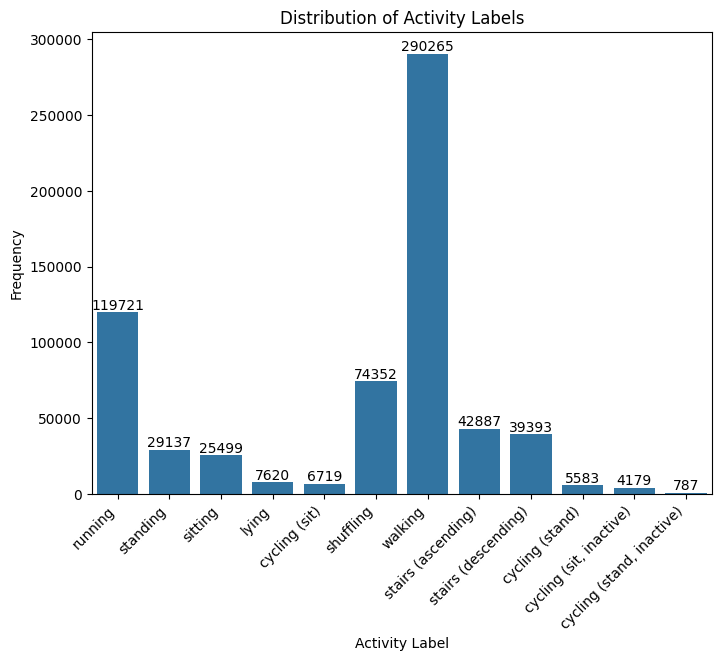

In [14]:
"""DISTRIBUTION OF ACTIVITY LABELS"""

# Calculate the frequency of each label
label_distribution = combined_data['label'].value_counts()
# Create a bar chart
plt.figure(figsize=(8, 6))
ax=sns.barplot(x=label_distribution.index, y=label_distribution.values)
# Get current tick labels and replace them with action names
# Add labels above the bars
for i in ax.containers:
    ax.bar_label(i,)


current_labels = plt.gca().get_xticks()  # Get current tick positions
plt.gca().set_xticks(label_distribution.index)
plt.gca().set_xticklabels([action_id_to_name[label] for label in current_labels], rotation=45, ha="right")
plt.xlabel('Activity Label')
plt.ylabel('Frequency')
plt.title('Distribution of Activity Labels')

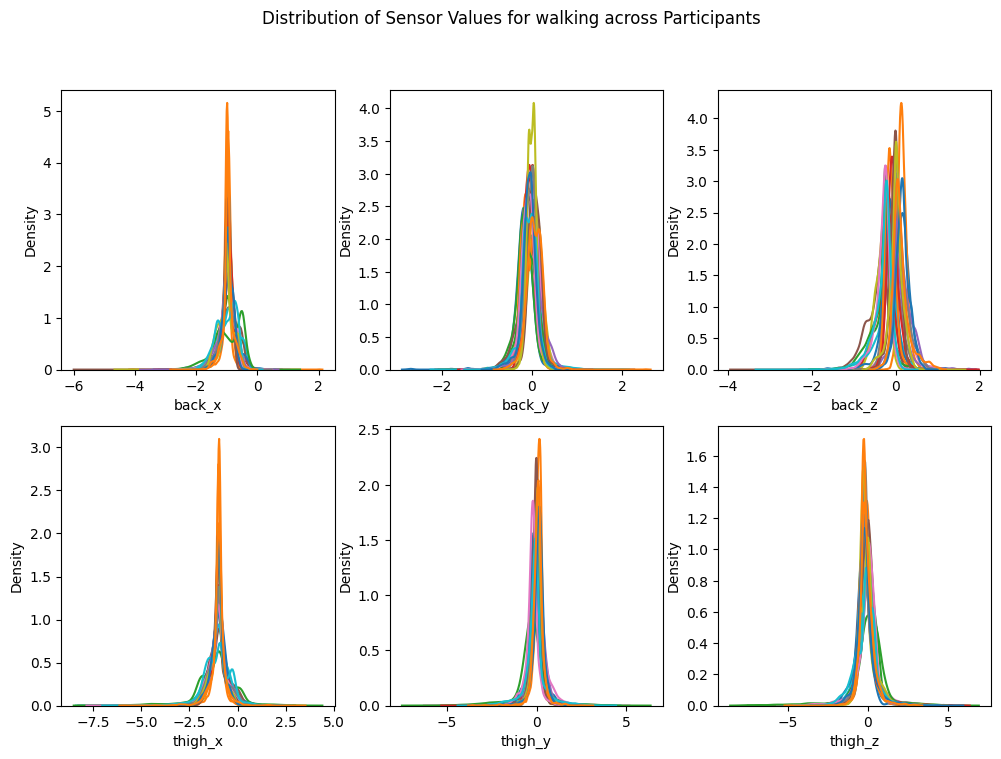

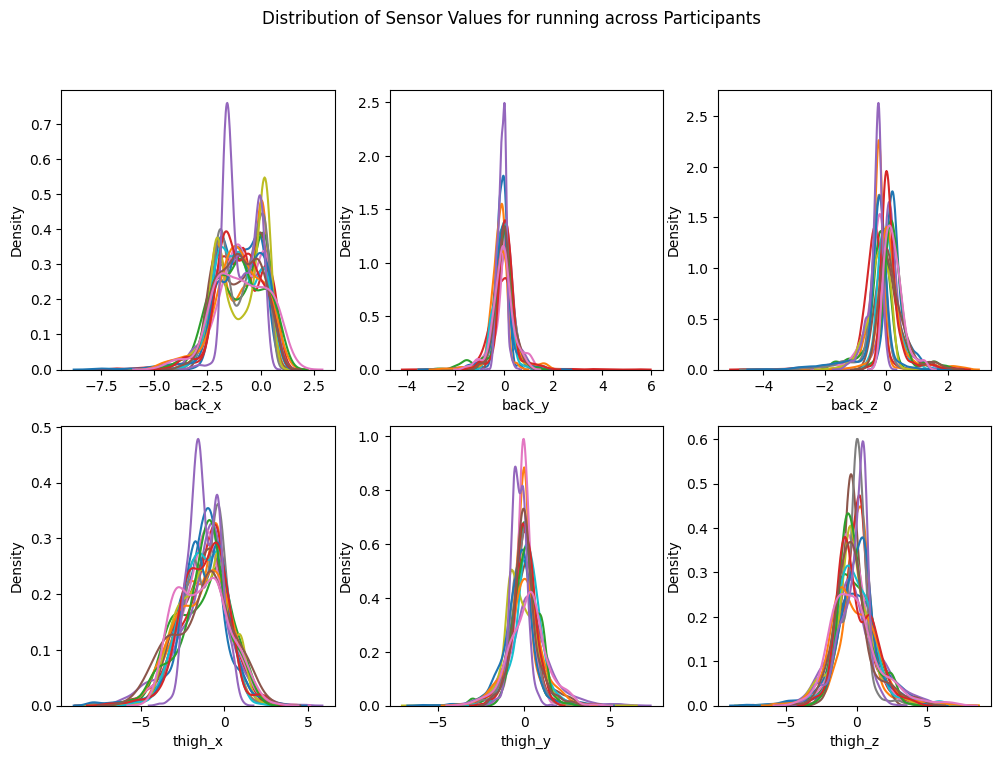

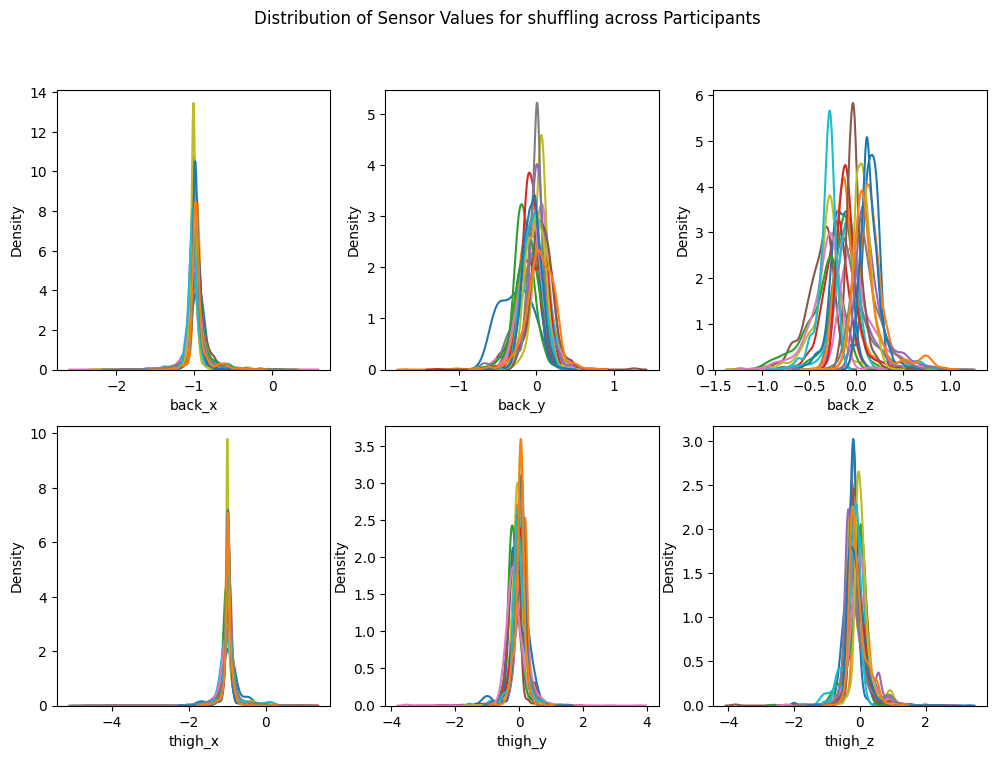

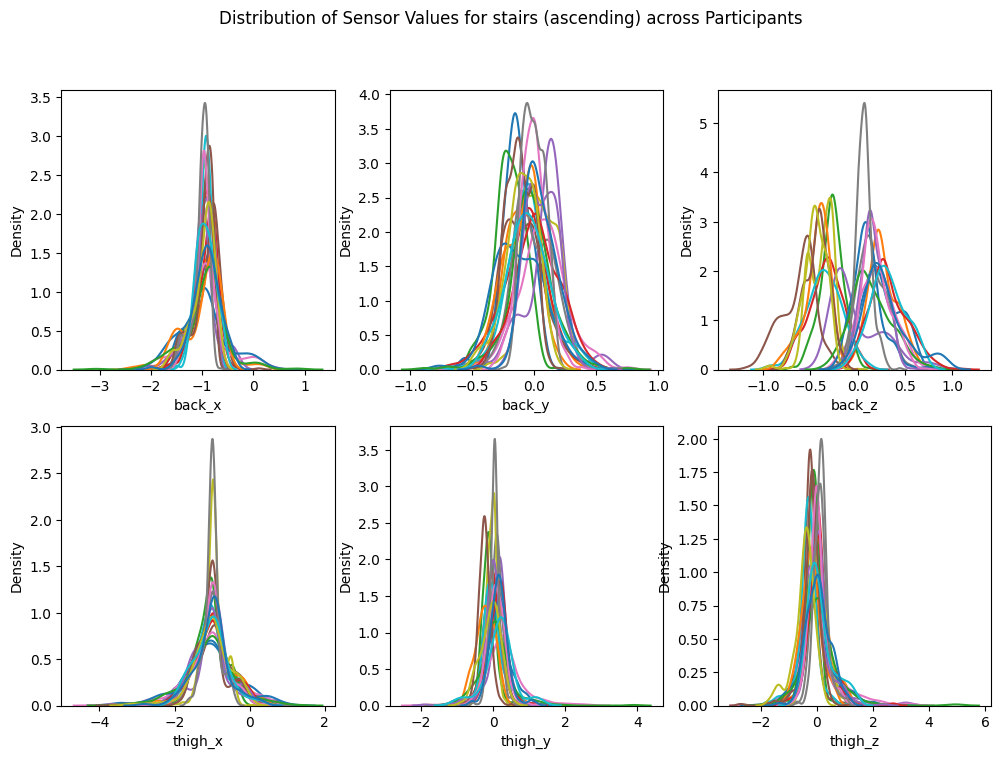

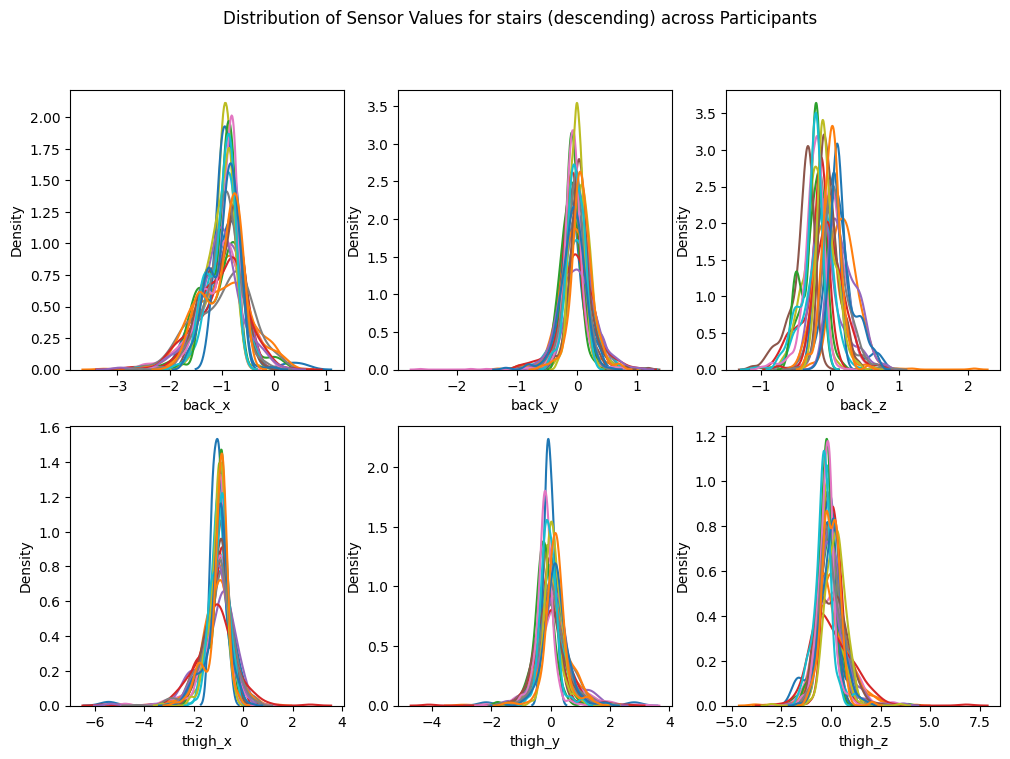

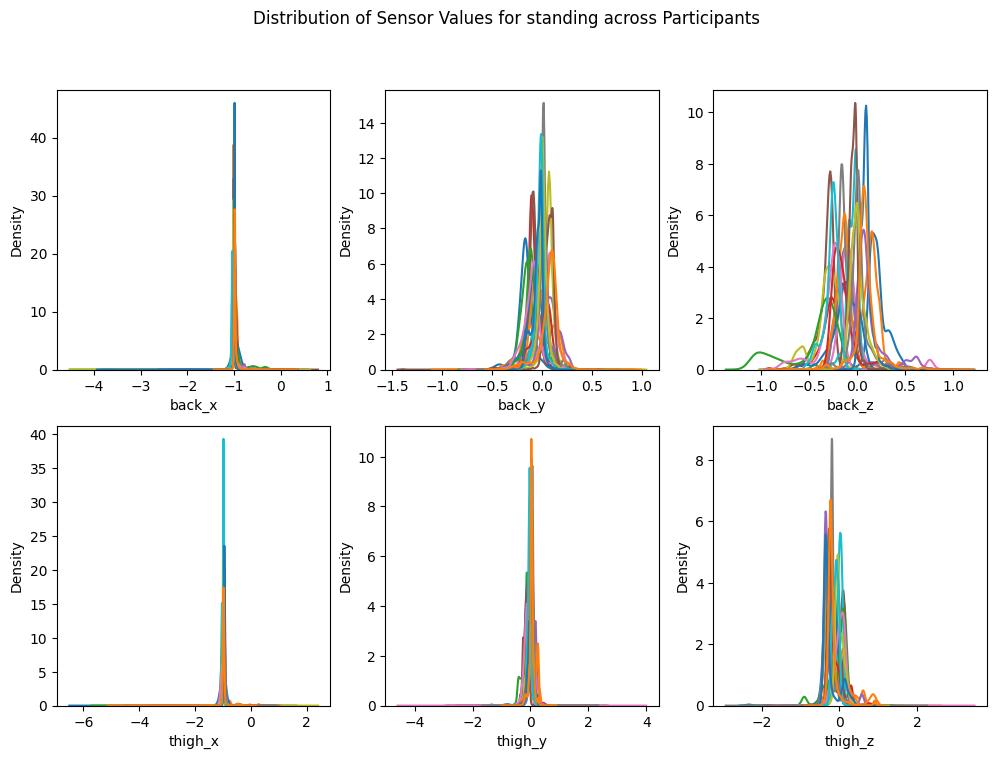

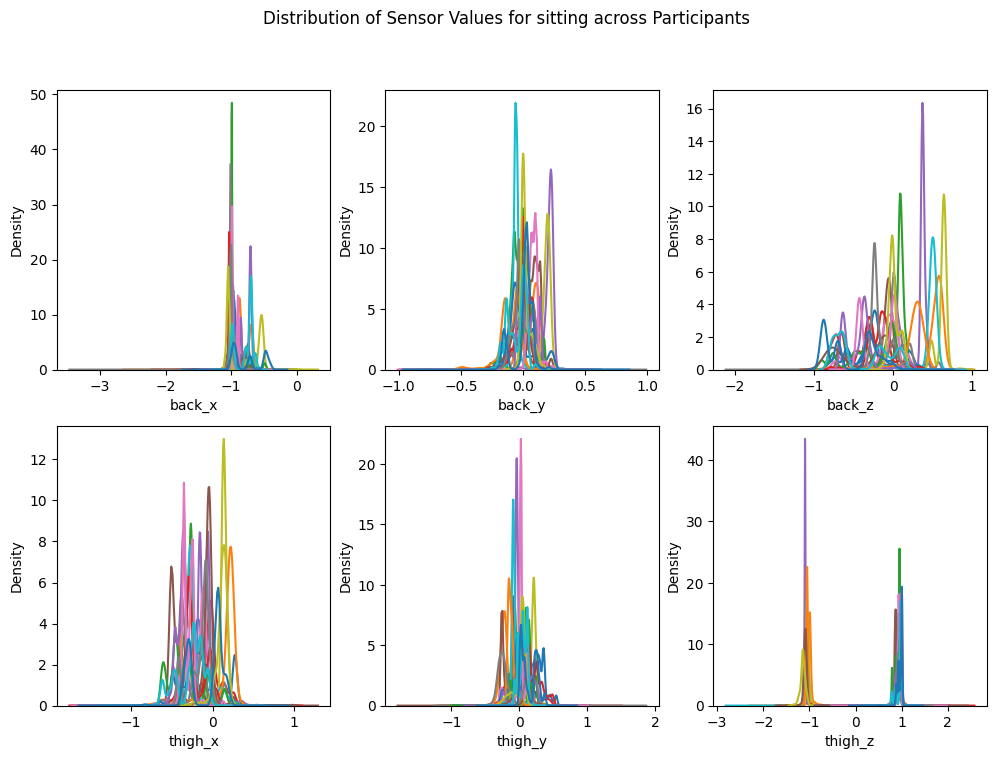

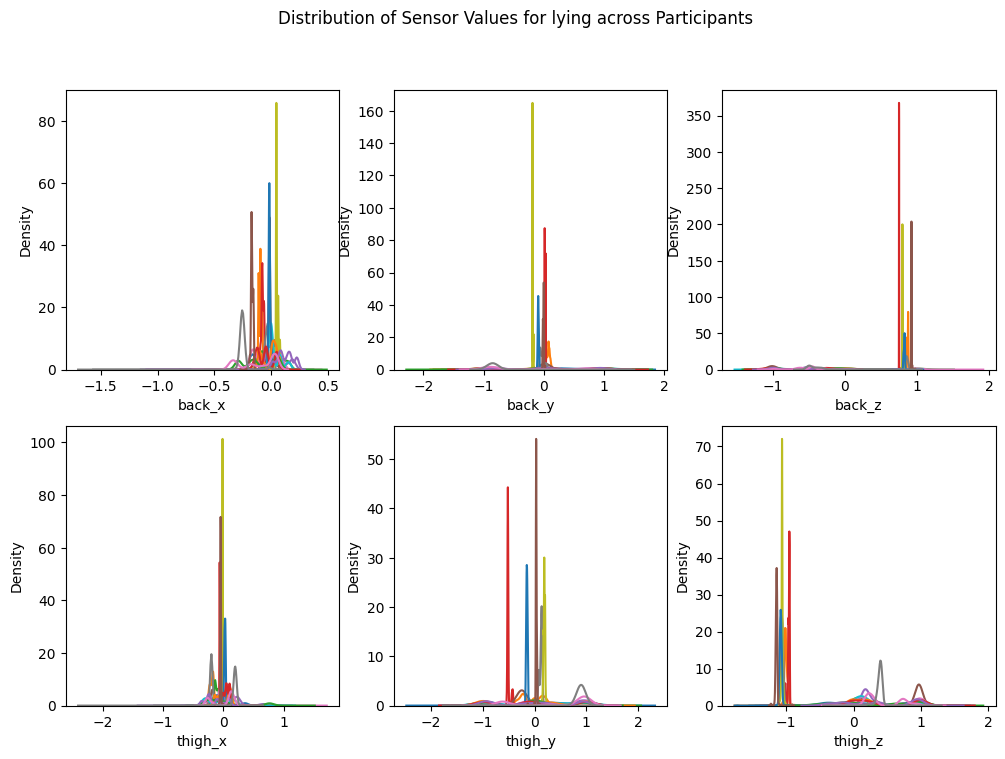

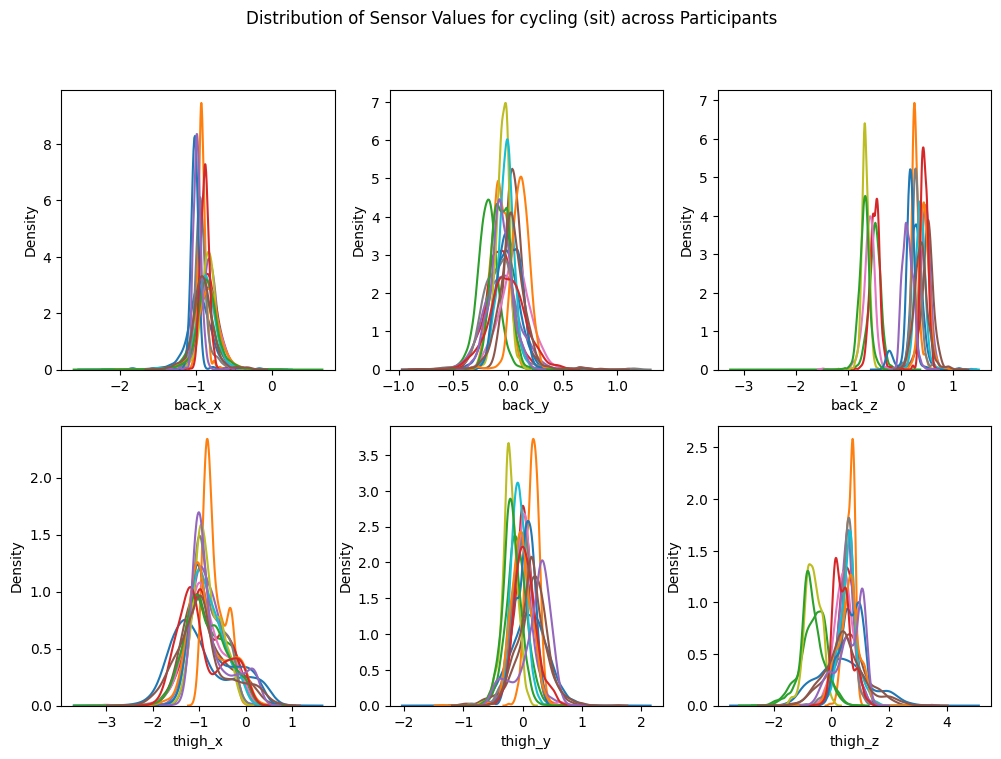

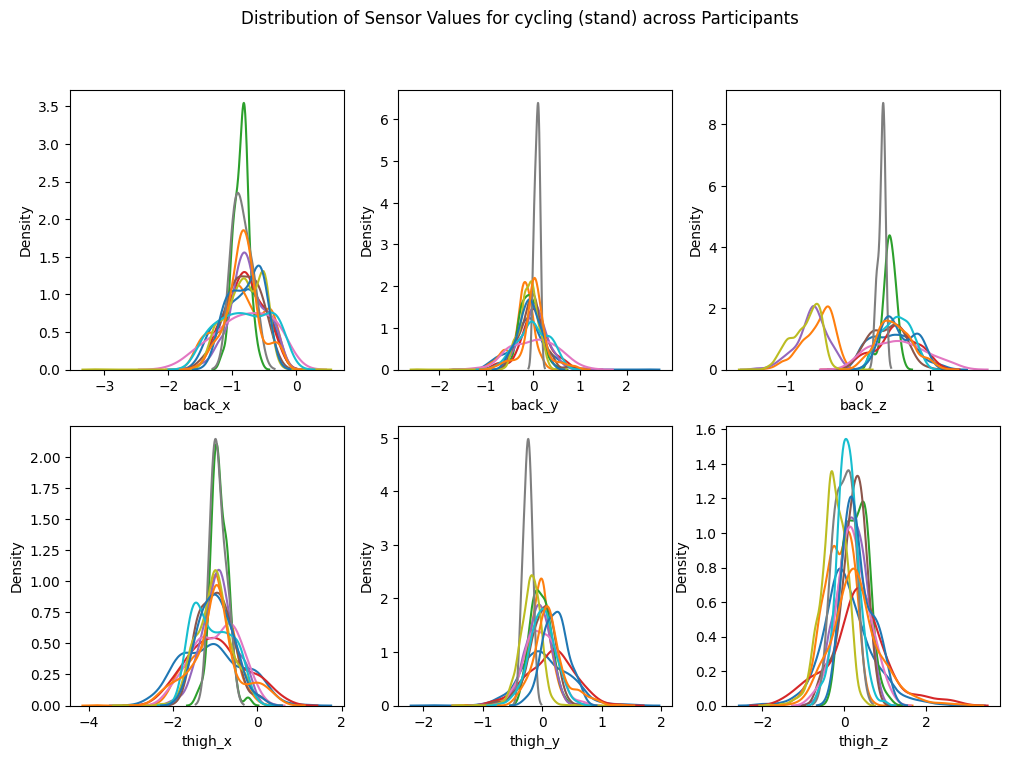

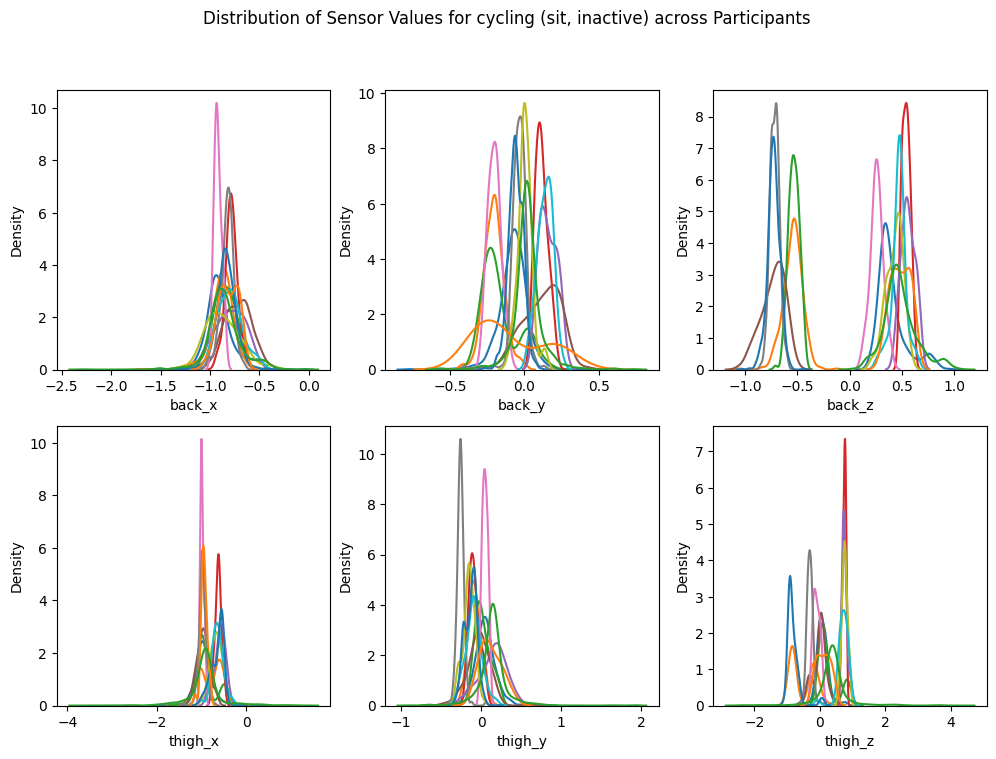

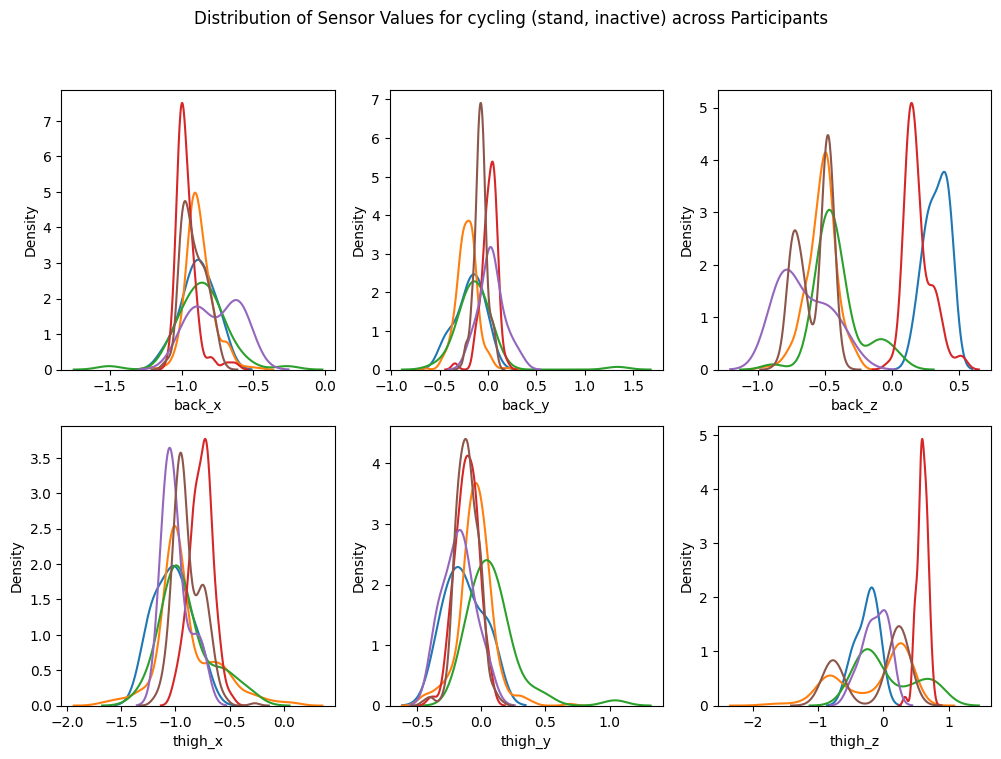

In [16]:
"""DISTRIBUTION OF SENSOR VALUES"""
# Plot histograms for each sensor value grouped by label across different participants
for label, groups in action_data_dict.items():
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Distribution of Sensor Values for {action_id_to_name[label]} across Participants')
    
    # Plot histograms for each sensor column
    for idx, sensor_col in enumerate(sensor_columns, 1):
        plt.subplot(2, 3, idx)
        
        # Plot data from different participants on the same graph
        # Loop through each action label
        for group in groups:
            # Plot PDF for sensor data of the current action label with KDE
            sns.kdeplot(group[sensor_col], fill=False)
    
    # Add a small pause to allow plots to display properly
    plt.pause(1.0)

In [18]:
#Create a column to identify where the action changes
combined_data['action_change'] = (combined_data['label'] != combined_data['label'].shift(1)).cumsum()
#Group by action and then by action_change
grouped = combined_data.groupby('label')

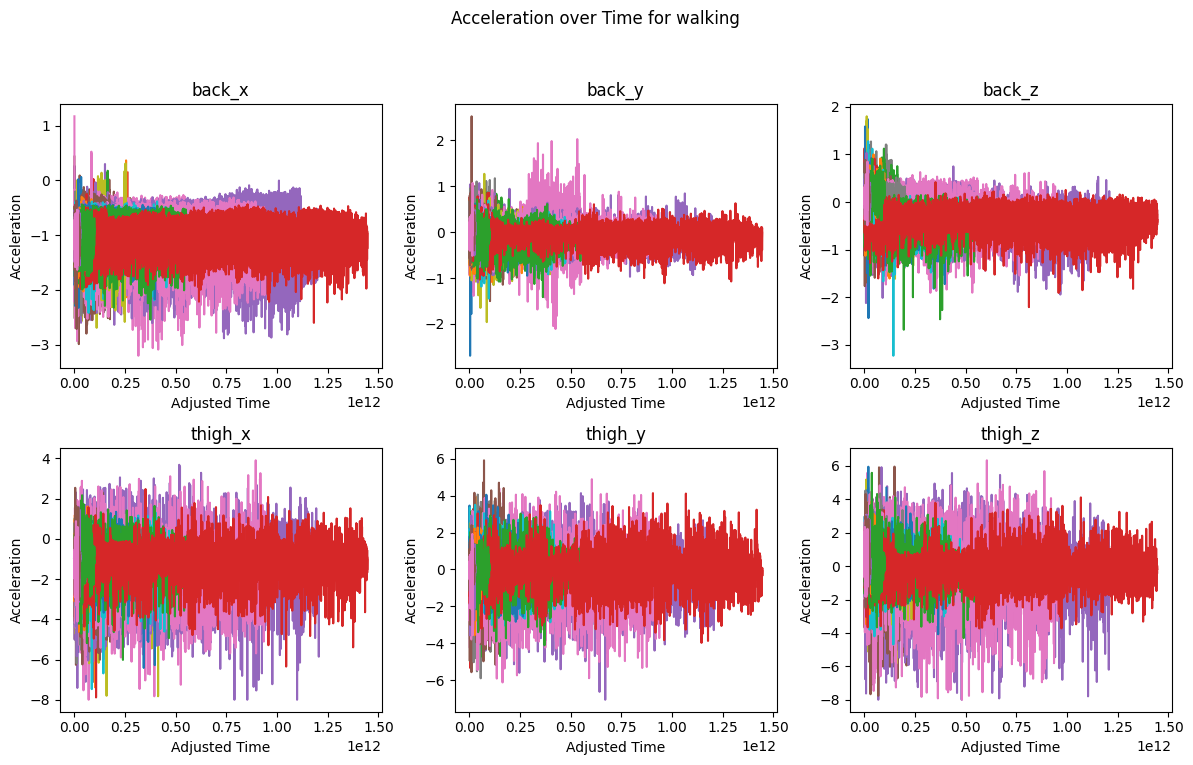

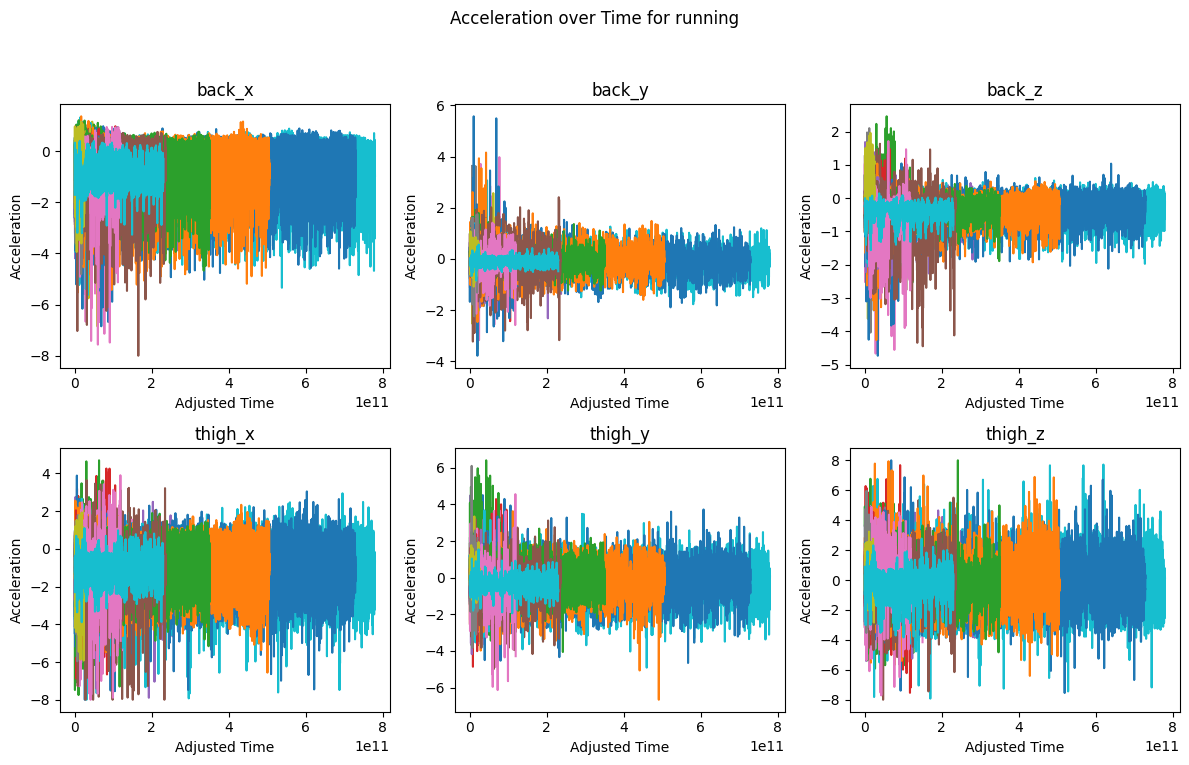

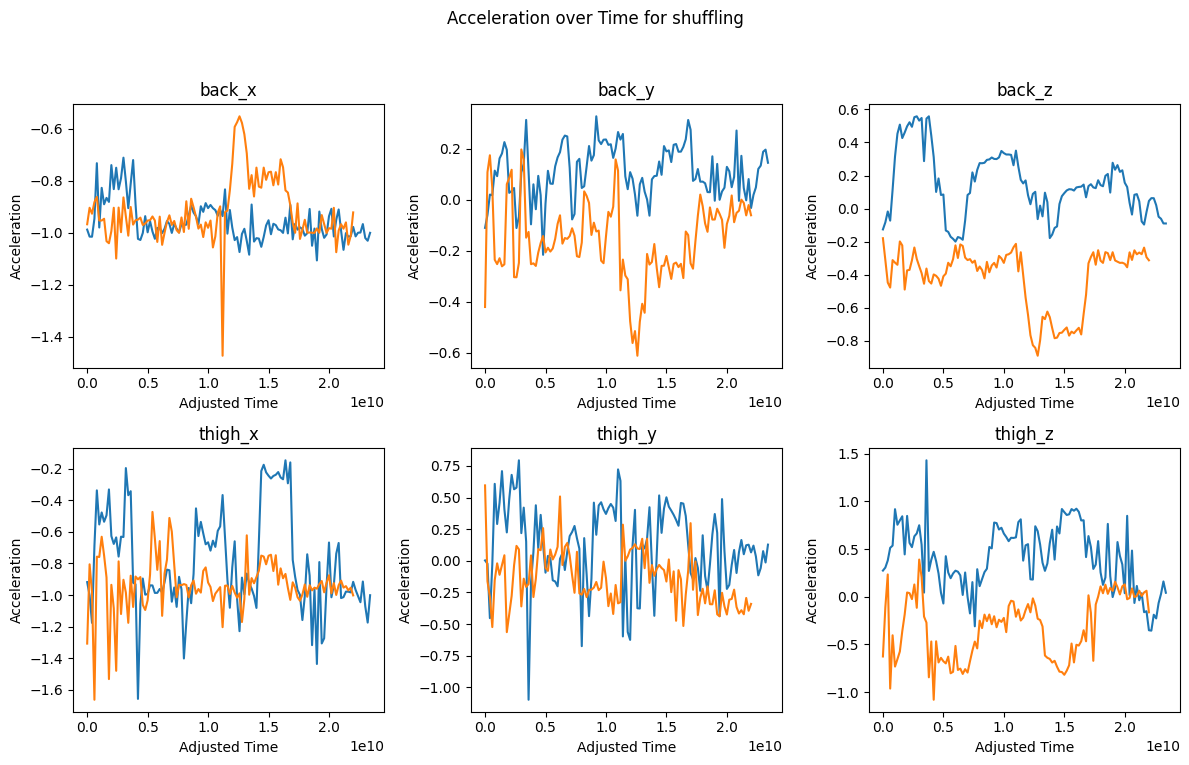

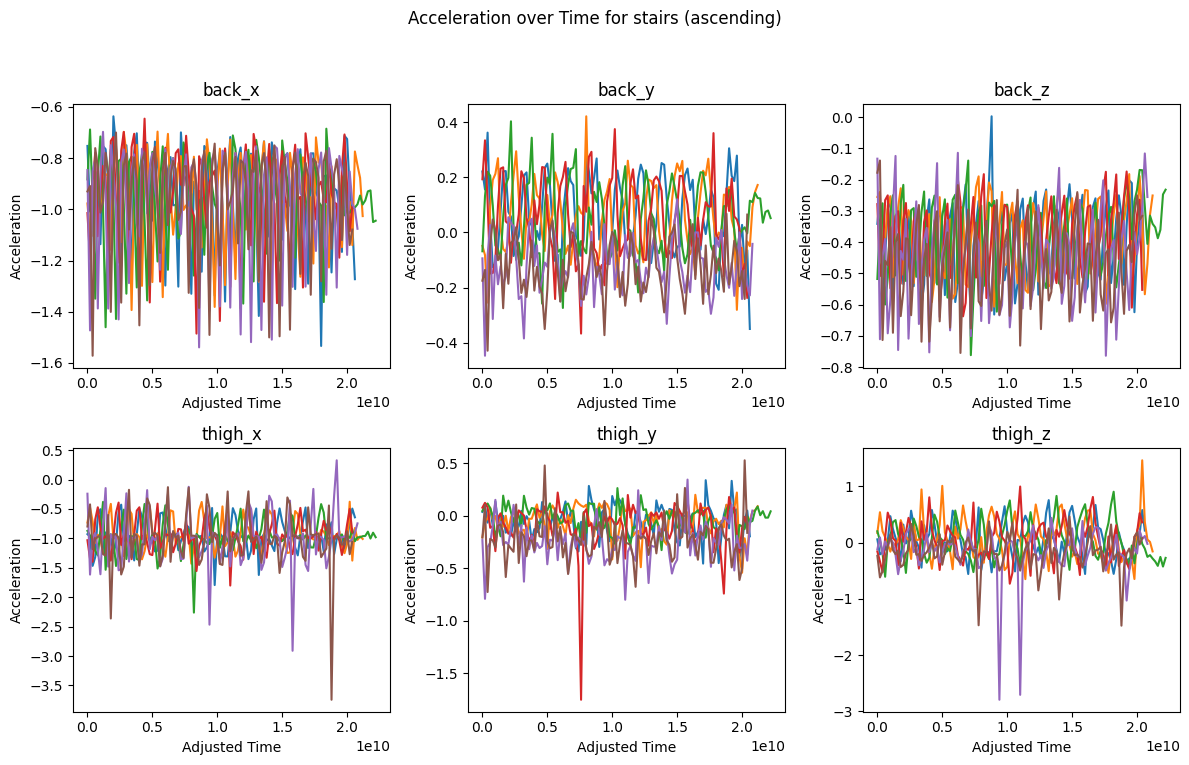

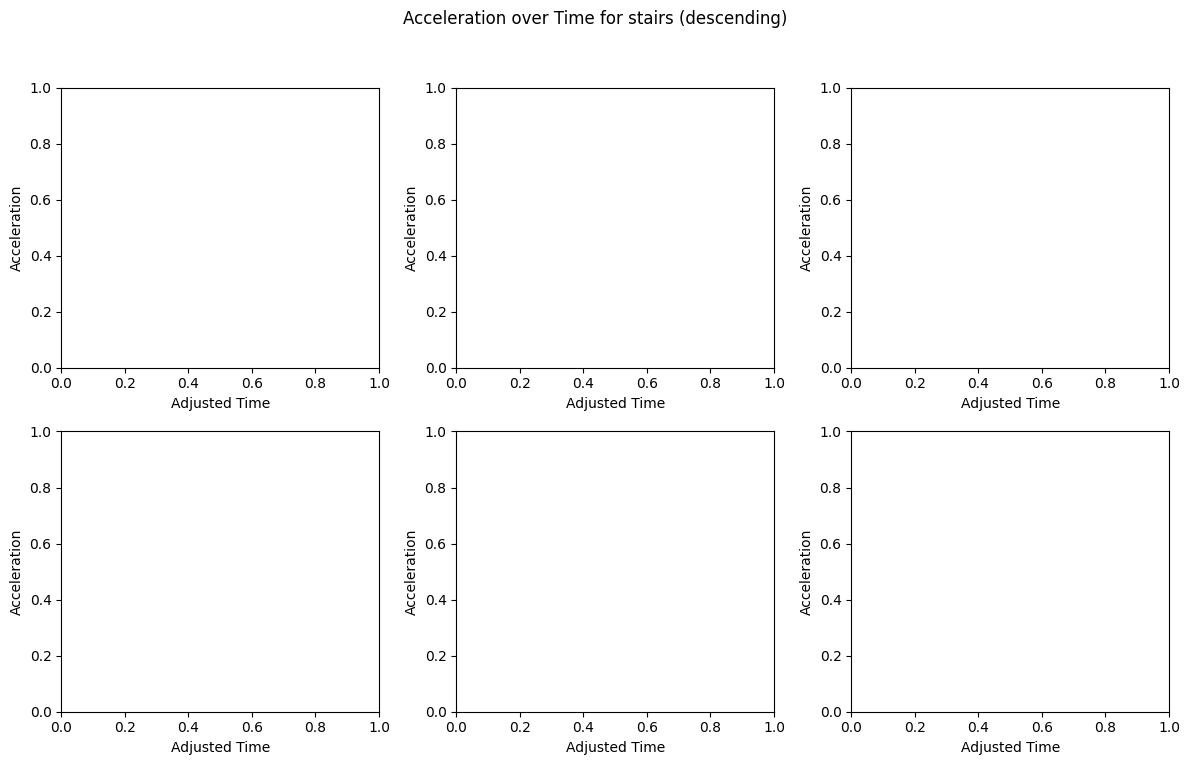

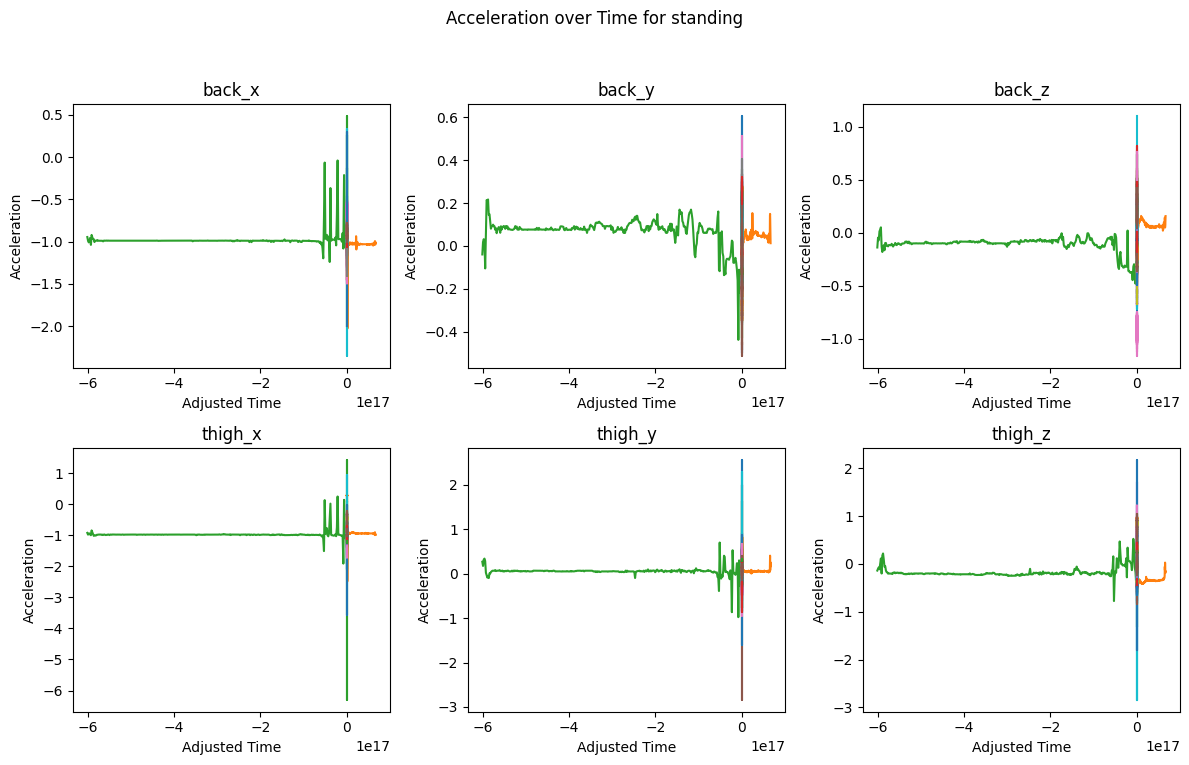

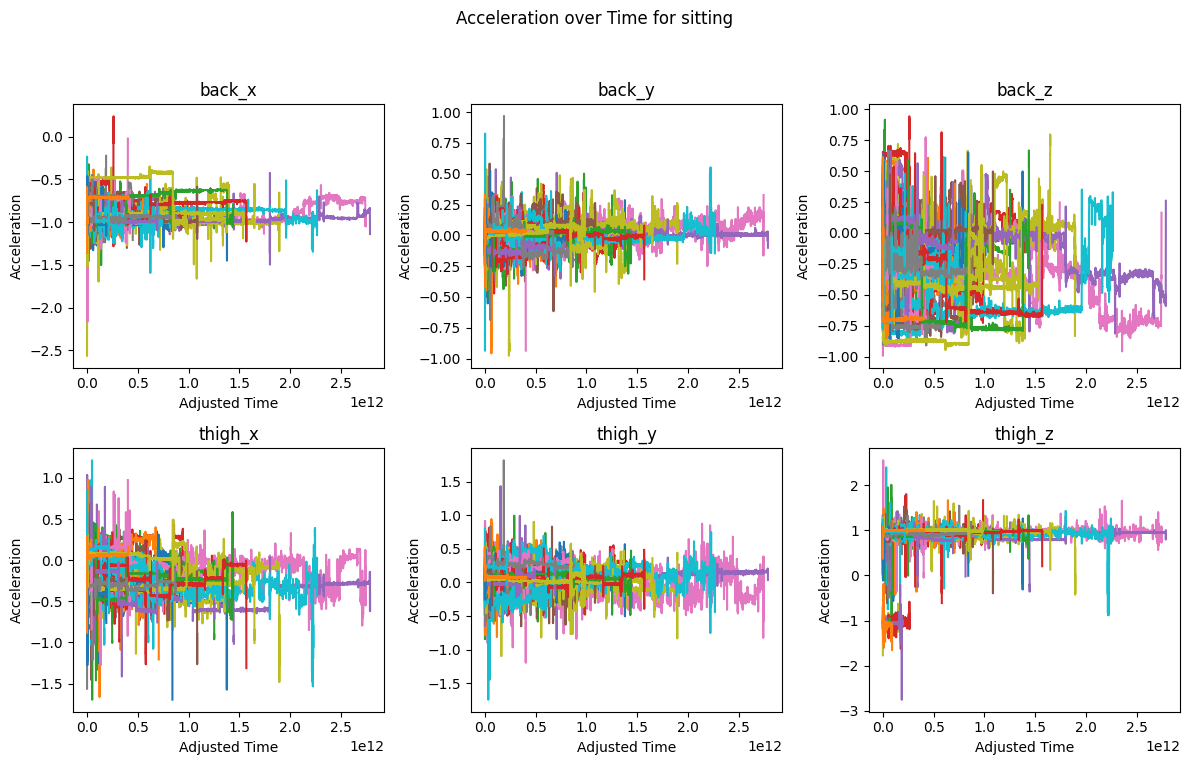

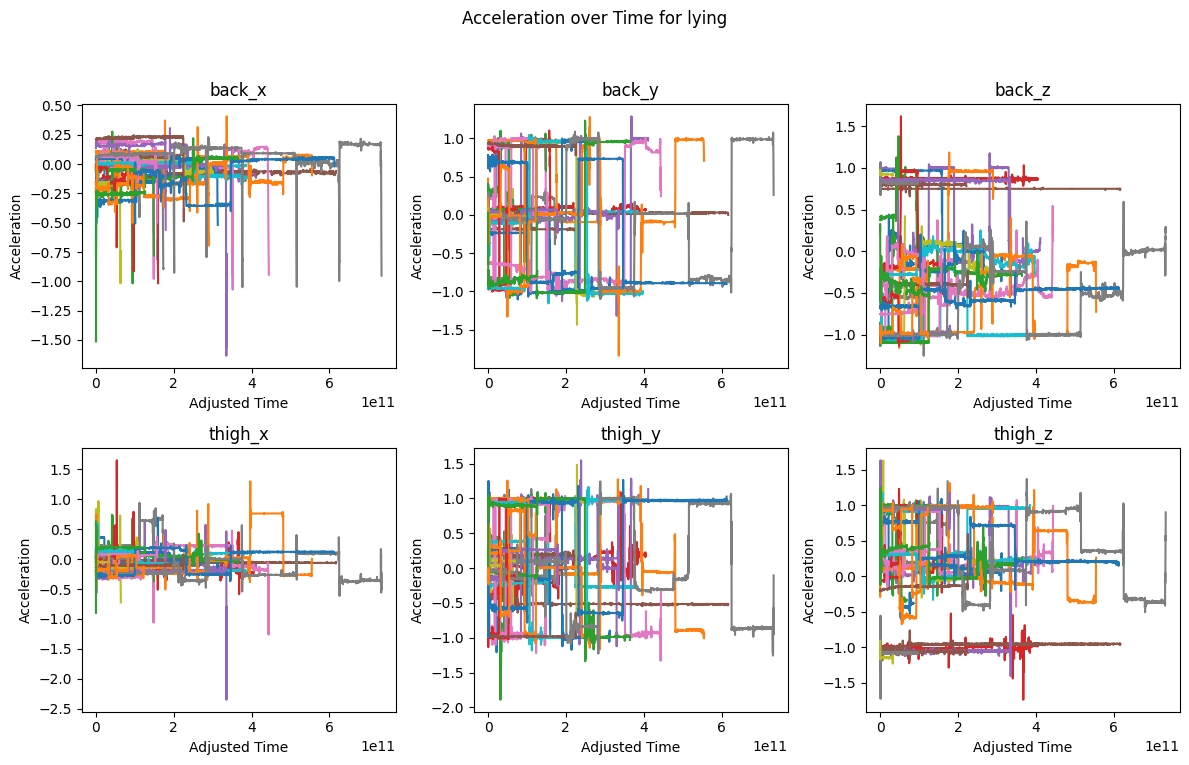

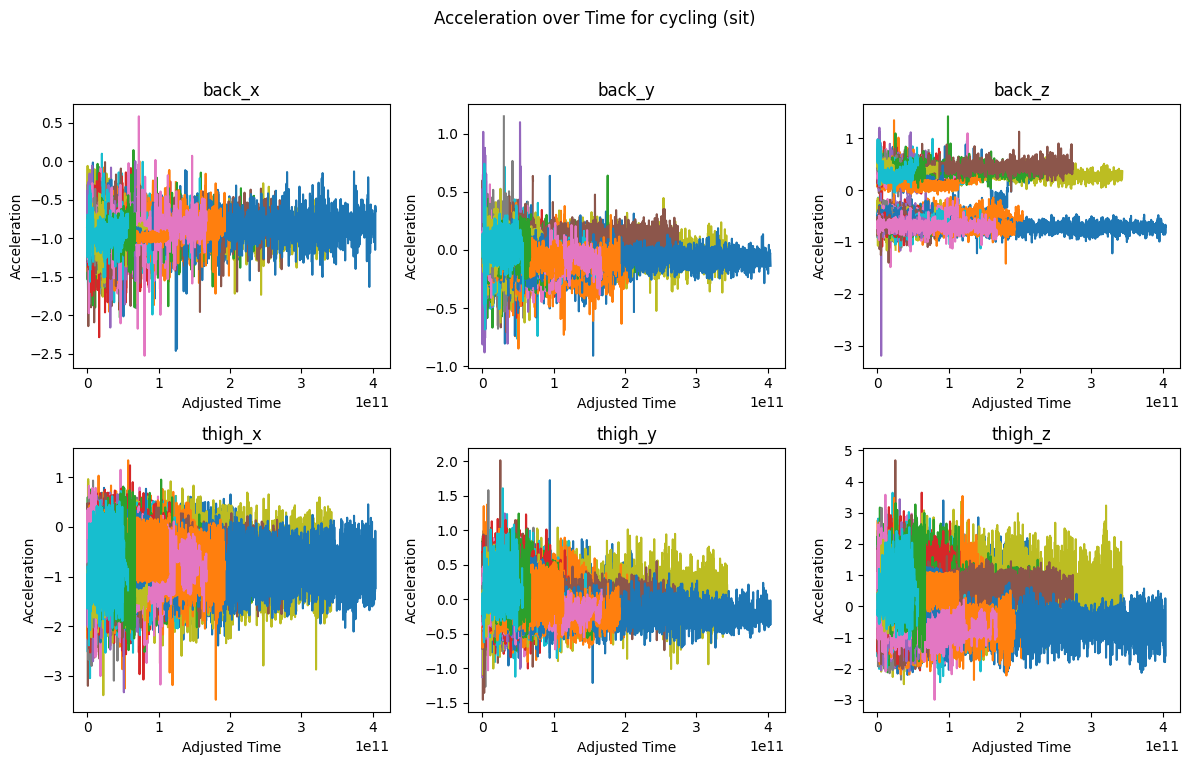

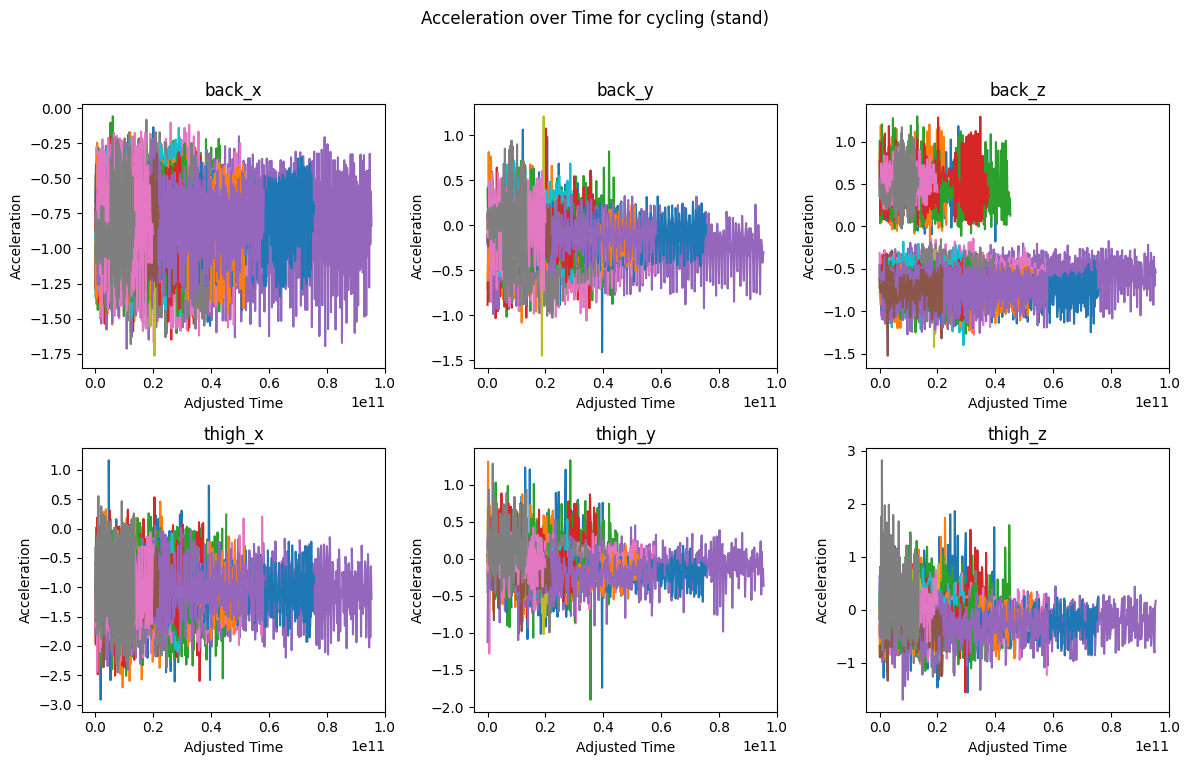

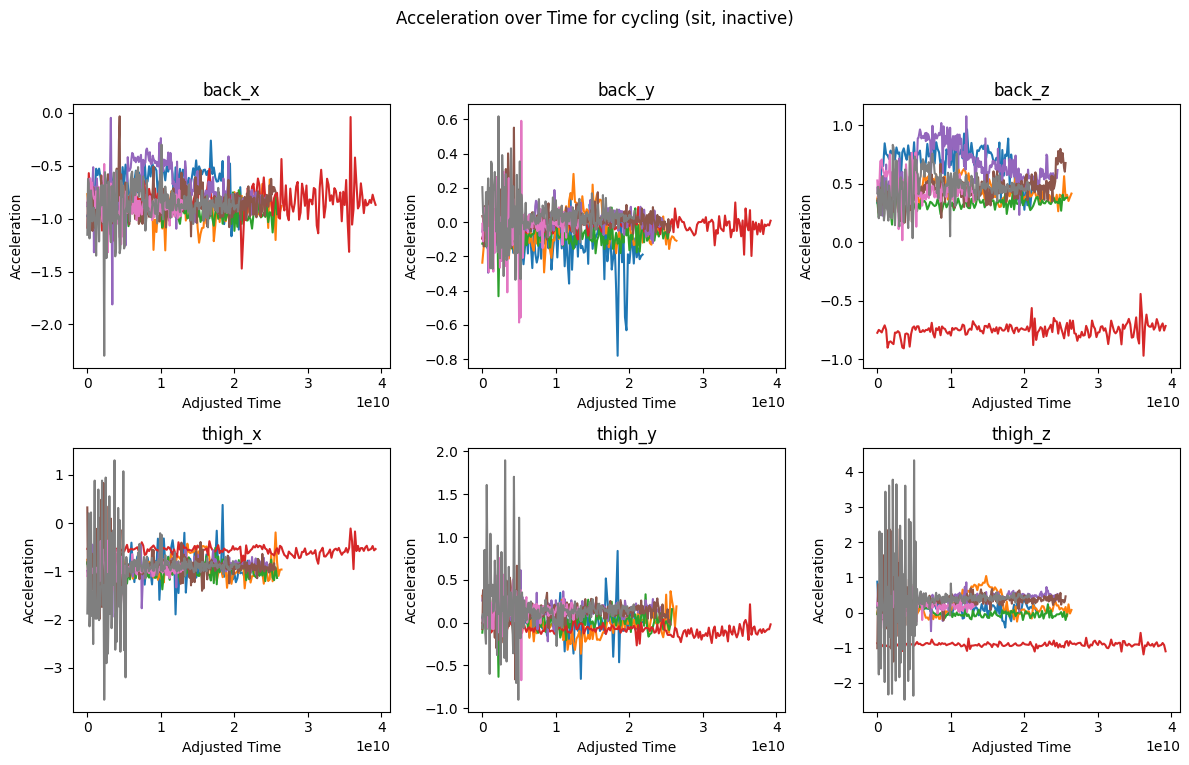

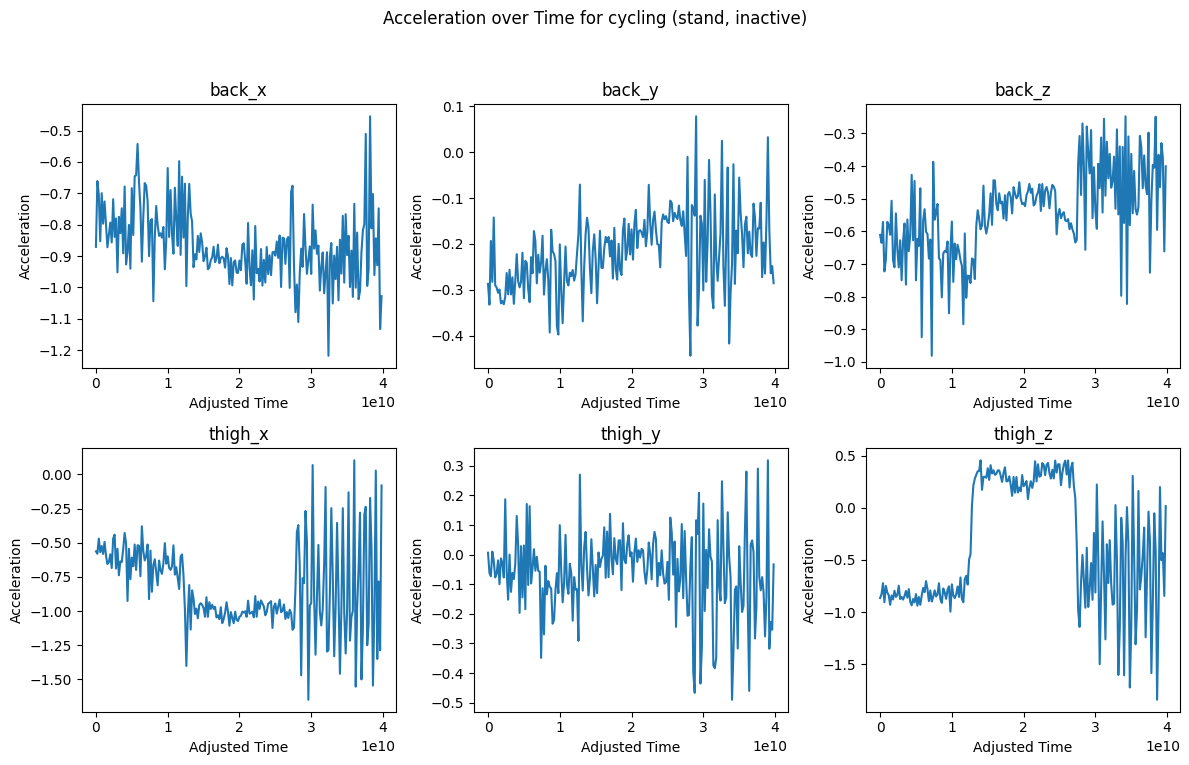

In [19]:
"""ACCELARATION OF ACTIONS IN TIME"""

# Iterate through each group (activity label)
for label, group in grouped:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'Acceleration over Time for {action_id_to_name[label]}')
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    action_times= group.groupby('action_change')

    for key,action in action_times:
        if len(action)>100:
            beginning = datetime.strptime(action['timestamp'].iloc[0], '%Y-%m-%d %H:%M:%S.%f')
            ending = datetime.strptime(action['timestamp'].iloc[-1], '%Y-%m-%d %H:%M:%S.%f')

            duration = (ending - beginning).total_seconds()
            step=duration/(len(action)-1)
            
            # Generate the array from 0 to the duration with the calculated step size
            time = np.arange(0, duration + step/2, step)
            time = [timedelta(seconds=seconds) for seconds in time] # Convert to timedelta objects

            # Iterate through the sensor columns and plot each one in a different subplot
            for i, sensor_col in enumerate(sensor_columns):
                sns.lineplot(x=time, y=action[sensor_col], ax=axes[i])
                axes[i].set_title(sensor_col)
    
    # Set common labels for the figure
    for ax in axes:
        ax.set_xlabel('Adjusted Time')
        ax.set_ylabel('Acceleration')

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])